In [1]:
import numpy
import scipy.io
import time



# CARICO DATI

#tFft = 8192
tFft = 4096
nfft = 128
tObs = nfft*4096
nPunti = 2
cands = 100
binfreq = 1/tFft

freqmin = 80
freqmax = 80+128*2*binfreq
print(freqmax)

nfreq = 128*2

frequenze = numpy.arange(80,80+(nfreq+1)*binfreq,binfreq)
tempi = numpy.arange(0,nfft*4096,4096)
print(tempi[-1])
print(frequenze[-1])
print(nfreq)
peakmapTOT = numpy.random.choice([0,1],size = (nfreq,nfft))
print(peakmapTOT)
peaklinee = numpy.zeros(peakmapTOT.shape)

80.0625
520192
80.0625
256
[[0 1 0 ... 1 0 1]
 [0 1 1 ... 0 1 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 1]
 [0 0 1 ... 0 0 0]]


<IPython.core.display.Javascript object>


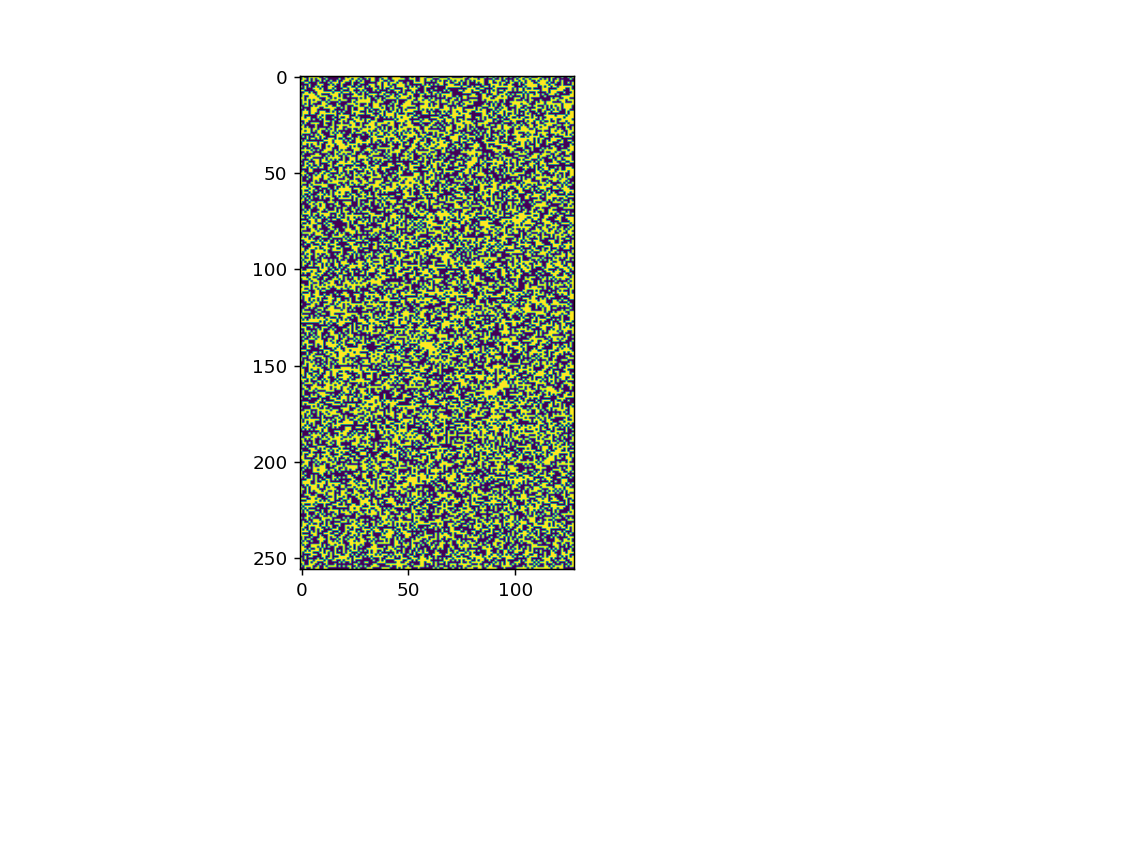

In [4]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.imshow(peakmapTOT, aspect = 0.9)

In [5]:


#percorsoDati = "dati/dati9mesi108HWI.mat"
#percorsoQuad = "quadHWI108.mat"
#percorsoPatch = "quadHWI108Ecl.mat"

#percorsoDati = "dati/dati9mesi108HWI.mat"
#percorsoQuad = ("quad%dLIL.mat" % tFft)
#percorsoPatch = ("quad%dEclNew.mat" % tFft)


percorsoDati = "/home/protoss/Documenti/TESI/wn100bkp/data/amplitude_4.mat"


#index = 9002 #signal
index = 4 #signal meno bello
#index = 5001
#index = 0

struttura1 = scipy.io.loadmat(percorsoDati)['H']
peakmap1 = struttura1[index].copy()
del struttura1

peakmapTOT = peakmap1


peaklinee = numpy.zeros(peakmapTOT.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/protoss/Documenti/TESI/wn100bkp/data/amplitude_4.mat'

In [6]:
#spindowns
spindownMin = -10e-10
spindownMax = 9e-10
nstepSpindown = 100
stepSpindown = (spindownMax-spindownMin)/nstepSpindown
#stepSpindown = stepFreq/tObs 

#nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)




peaklinee = numpy.zeros(peakmapTOT.shape)

peaklinee[200] = 1


colonne = numpy.arange(peaklinee.shape[1])
print(colonne.size)
righe = numpy.round(numpy.arange(105,117,(117-105)/128)).astype(int)
print(righe.size)

peaklinee[righe,colonne] = 1


peaklinee = numpy.flip(peaklinee,0)

#peaklinee[:,10] = 1

128
128


<IPython.core.display.Javascript object>


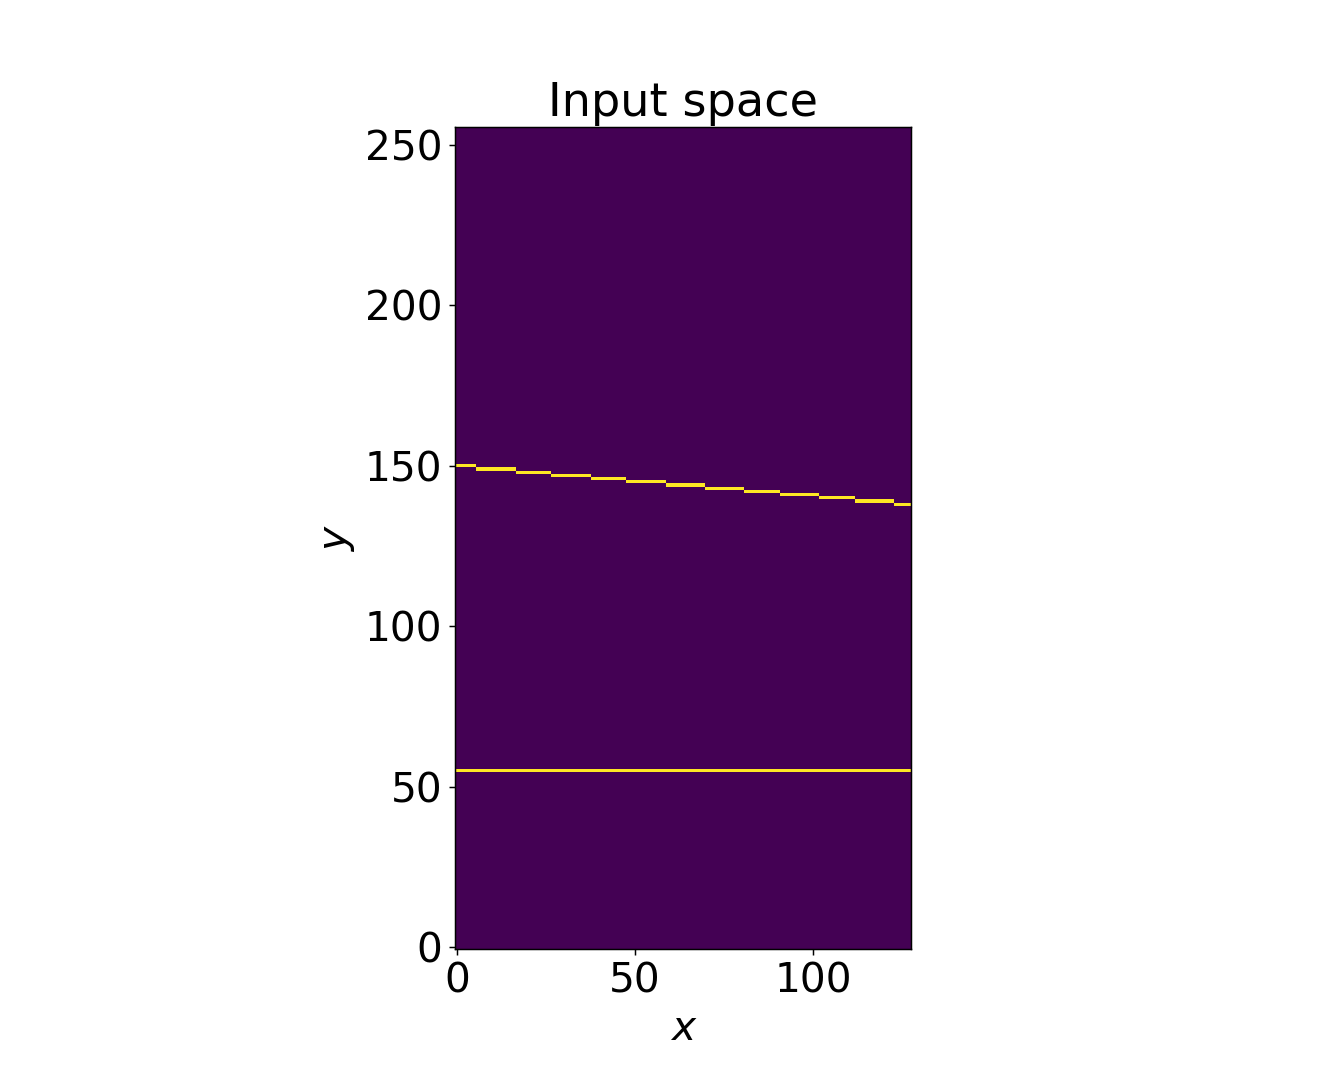

Text(0.5, 1.0, 'Input space')

In [7]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib notebook
mpl.rcParams['font.size'] = 22
pyplot.figure(figsize=(10, 8))
#a = pyplot.scatter(numpy.arange(tempiUnici.size),tempiUnici/30, s = 0.5)
a = pyplot.imshow(peaklinee, cmap = 'viridis',origin = 'lower', interpolation = 'none',aspect = 0.9)
pyplot.xlabel('$x$',fontsize = 22)
pyplot.ylabel('$y$', fontsize = 22)
pyplot.title('Input space', fontsize = 25)
#pyplot.savefig('simpeak.pdf', format='pdf')

In [8]:
import tensorflow as tf
import numpy
import scipy.io
import time

sessione = tf.Session()

# CARICO DATI

#tFft = 8192

#percorsoDati = "/home/protoss/Documenti/TESI/wn100bkp/data/amplitude_4.mat"


#index = 9002 #signal
#index = 4 #signal meno bello
#index = 5001
#index = 0

#struttura1 = scipy.io.loadmat(percorsoDati)['H']
#peakmap1 = struttura1[index].copy()
#del struttura1

#struttura2 = scipy.io.loadmat(percorsoDati)['L']
#peakmap2 = struttura2[index].copy()
#del struttura2

#struttura3 = scipy.io.loadmat(percorsoDati)['V']
#peakmap3 = struttura3[index].copy()
#del struttura3


#strutturaTOT = struttura1 + struttura2 #+ struttura3


###############################


def noncorr():
	freqMin = numpy.amin(frequenze)
	freqIniz = freqMin - stepFreq/2 -stepFreqRaffinato
	freqNonCor = (frequenze -freqIniz)/stepFreqRaffinato-round(enhancement/2+0.001)
	#freqNonCor = tf.constant(freqNonCor, dtype = tf.float32)
	return freqNonCor, freqIniz


def inDaHough(freqHM):
	#calcola la hough per ogni step di spindown
	def houghizza(stepIesimo):
		sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
		#sdTimed = tf.cast(sdTimed, dtype=tf.float32)
	
		appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
		appoggio = tf.cast(appoggio, dtype=tf.int32)
		
		valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
		return valorisx

	houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

	def sliceInt():
		#faccio integrazione finale (vecchia versione senza conv)
		semiLarghezza = tf.round(enhancement/2+0.001)
		semiLarghezza = tf.cast(semiLarghezza, tf.int32)
		houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
		houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
		return houghInt

	
	hough = sliceInt()
	#hough = convInt()
	houghinal = tf.cumsum(hough, axis = 1)
	
	return houghinal
	#return houghDiff
    
    


#tFft = 4096
#tObs = 1/5 #mesi
#tObs = tObs*30*24*60*60
#nPunti = 2
#cands = 32
primaFreq = 1/tFft

#maximumCand = numpy.array()


#peakmapTOT = strutturaTOT[index]
nonzeri = numpy.nonzero(peakmapTOT)
peakmapTOT[nonzeri] = 1

In [9]:

#sparsa = numpy.nonzero(peakmapTOT)
sparsa = numpy.nonzero(peaklinee)

frequenze,tempi = sparsa
tempi = tempi+1
frequenze = frequenze / tFft + 1
pesi = numpy.ones(sparsa[0].size)




#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 2000
#securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
#enhancement = 1
stepFreqRaffinato =  stepFreq/enhancement
nstepsFreq = securbelt+(numpy.amax(frequenze)-numpy.amin(frequenze) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato


epoca = numpy.int(128/2)

#spindowns
spindownMin = -9e-10
spindownMax = 9e-10
nstepSpindown = 100
stepSpindown = (spindownMax-spindownMin)/nstepSpindown

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)
print(numpy.where(spindowns == numpy.amin(numpy.absolute(spindowns))))
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi, dtype=tf.float64)

pesiTF = tf.constant(pesi,dtype=tf.float32)

spindownsTF = tf.constant(spindowns, dtype=tf.float32) 

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float32)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int32)

nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

freq, freqIn = noncorr()

freqTF = tf.constant(freq, dtype = tf.float32)
houghmap = inDaHough(freqTF)
hough = sessione.run(houghmap)





(array([50]),)
Instructions for updating:
Colocations handled automatically by placer.


<IPython.core.display.Javascript object>


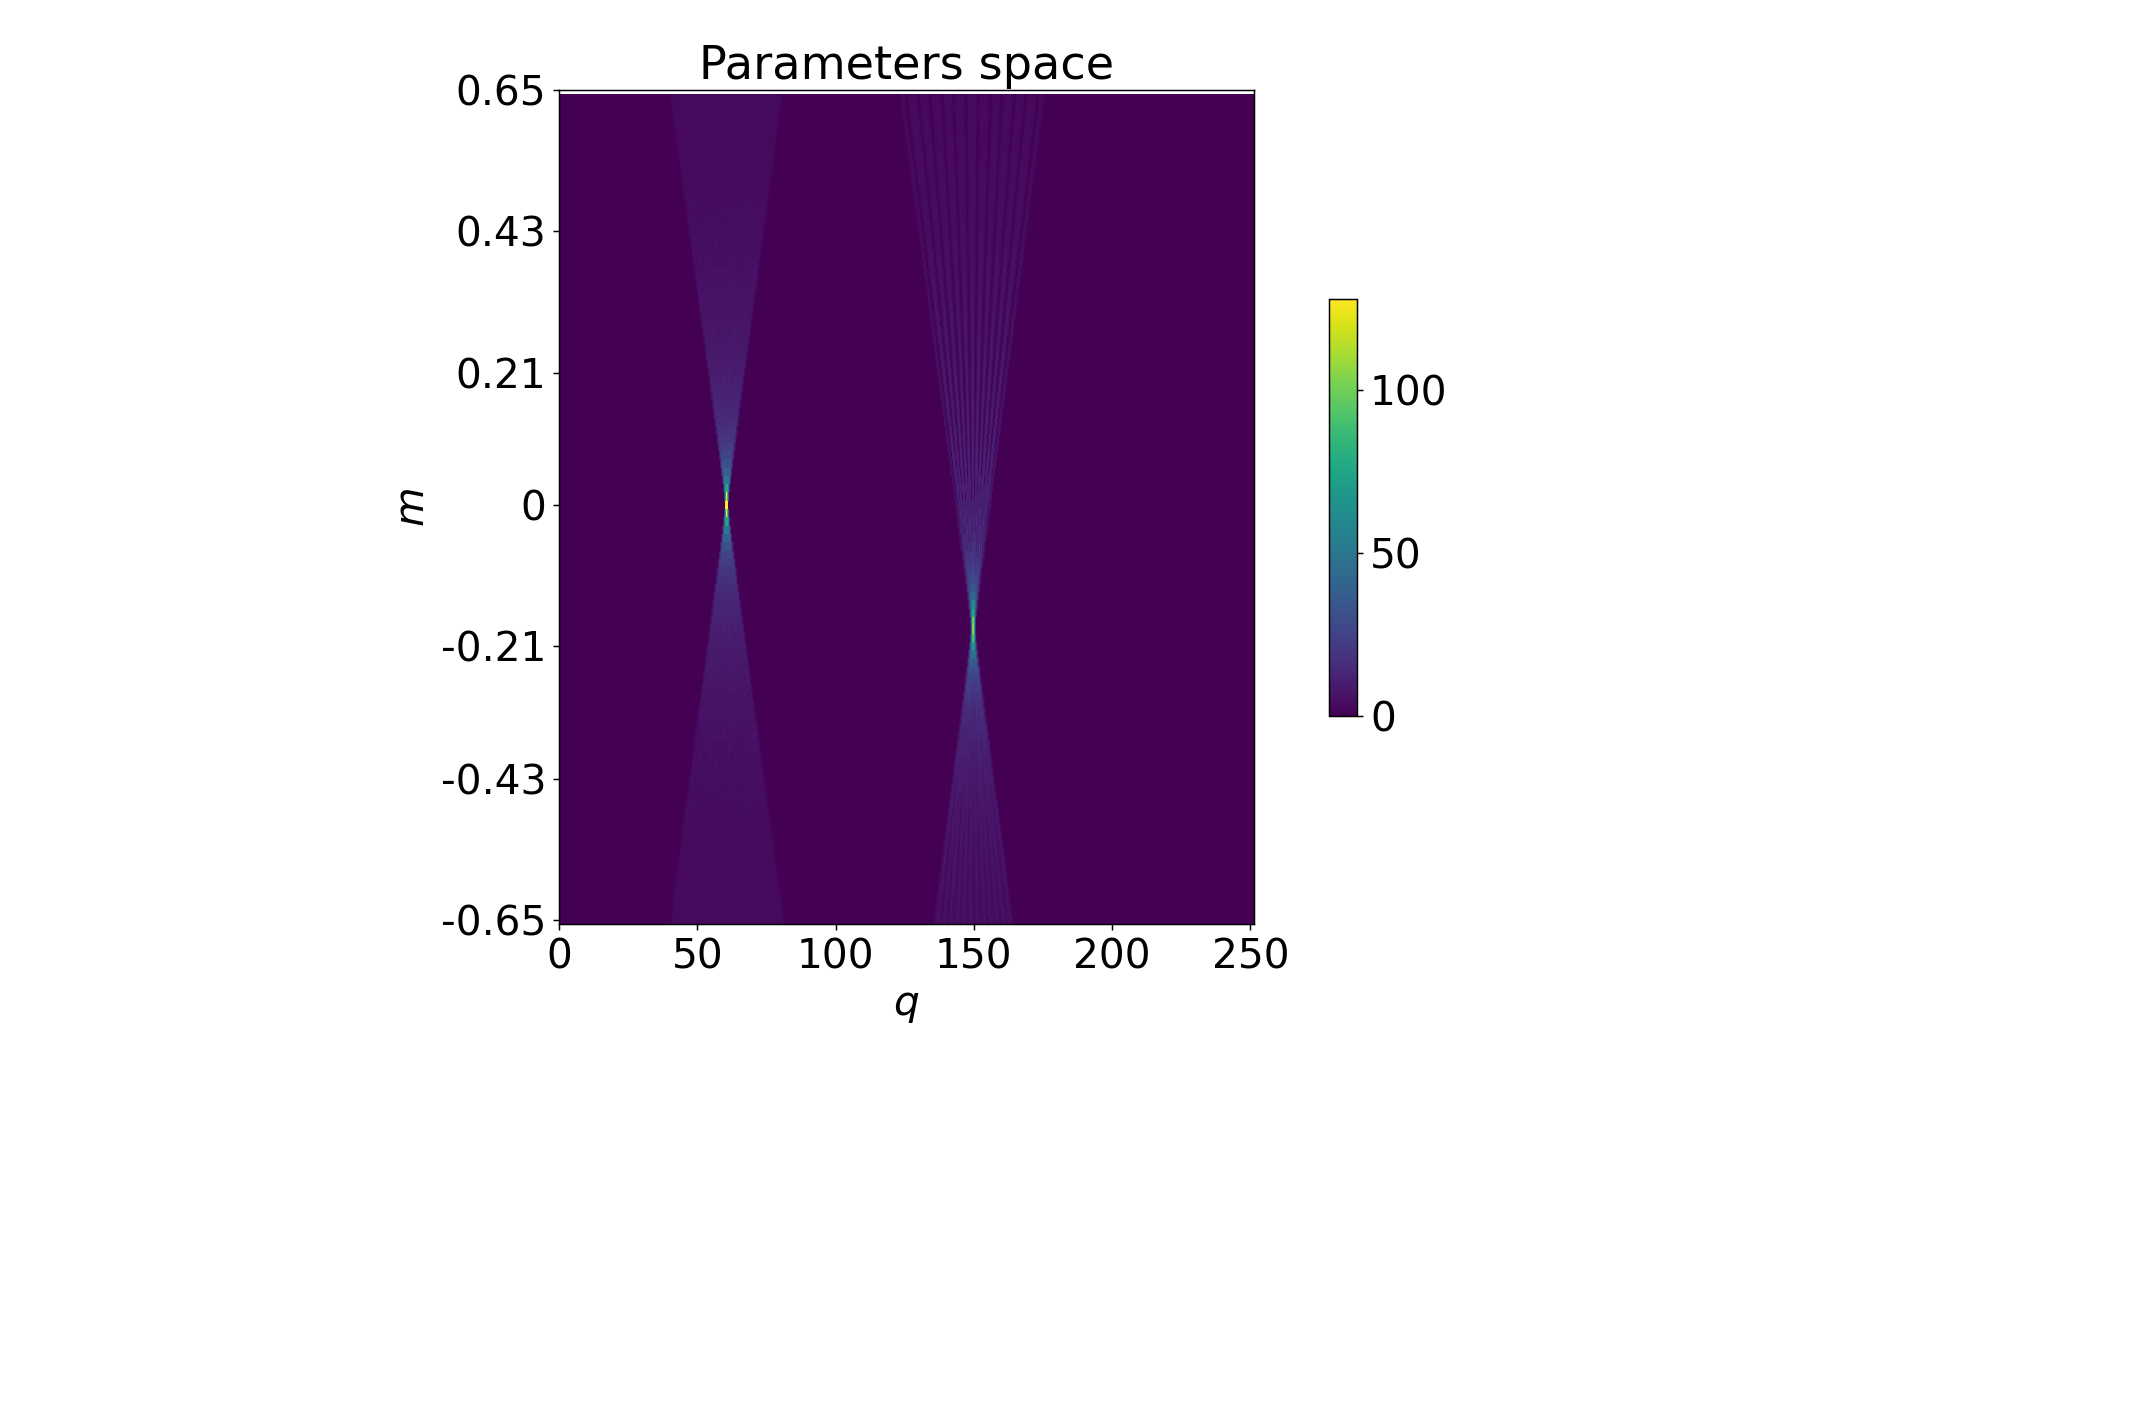

[ 0.651    0.63798  0.62496  0.61194  0.59892  0.5859   0.57288  0.55986
  0.54684  0.53382  0.5208   0.50778  0.49476  0.48174  0.46872  0.4557
  0.44268  0.42966  0.41664  0.40362  0.3906   0.37758  0.36456  0.35154
  0.33852  0.3255   0.31248  0.29946  0.28644  0.27342  0.2604   0.24738
  0.23436  0.22134  0.20832  0.1953   0.18228  0.16926  0.15624  0.14322
  0.1302   0.11718  0.10416  0.09114  0.07812  0.0651   0.05208  0.03906
  0.02604  0.01302 -0.      -0.01302 -0.02604 -0.03906 -0.05208 -0.0651
 -0.07812 -0.09114 -0.10416 -0.11718 -0.1302  -0.14322 -0.15624 -0.16926
 -0.18228 -0.1953  -0.20832 -0.22134 -0.23436 -0.24738 -0.2604  -0.27342
 -0.28644 -0.29946 -0.31248 -0.3255  -0.33852 -0.35154 -0.36456 -0.37758
 -0.3906  -0.40362 -0.41664 -0.42966 -0.44268 -0.4557  -0.46872 -0.48174
 -0.49476 -0.50778 -0.5208  -0.53382 -0.54684 -0.55986 -0.57288 -0.5859
 -0.59892 -0.61194 -0.62496 -0.63798 -0.651  ]


In [10]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib notebook
mpl.rcParams['font.size'] = 22
pyplot.figure(figsize=(12, 8))

a = pyplot.imshow(hough[:,400:-50], cmap = 'viridis', origin = 'lower', interpolation = 'none', aspect = 30)

labelxtick = [0,50,100,150,200,250]
posxTick = [0,500,1000,1500,2000,2500]
pyplot.xticks(posxTick,labelxtick)

sdveri = (-0.1953/15)*(numpy.arange(101)-50)
print(sdveri)

#labelytick = numpy.array([-50, -25, 0, 25, 50])
sdlabel = numpy.array([0,17,33,50,66,83,100])
labelytick = sdveri[sdlabel]
labelytick = [-0.65, -0.43, -0.21, 0, 0.21, 0.43, 0.65]
posytick = sdlabel#numpy.arange(0,101,25)#[  0, 25 ,50, 75, 100]



pyplot.yticks(posytick, labelytick)

pyplot.colorbar(shrink = 0.5,aspect = 15)
pyplot.xlabel('$q$',fontsize = 22)
pyplot.ylabel('$m$',fontsize = 22)
pyplot.title('Parameters space', fontsize = 25)
pyplot.tight_layout()
pyplot.savefig('simphough.pdf', format='pdf')


In [11]:
colonne = numpy.arange(peakmapTOT.shape[1])
print(colonne.size)
righe = numpy.round(numpy.arange(135,151,(151-135)/128)).astype(int)
righe = numpy.flip(righe,0)
print(righe.size)

peakmapTOT[righe,colonne] = 1

128
128


[135 135 135 135 136 136 136 136 136 136 136 136 136 137 137 137 137 137
 137 137 138 138 138 138 138 138 138 138 138 139 139 139 139 139 139 139
 140 140 140 140 140 140 140 140 140 141 141 141 141 141 141 141 142 142
 142 142 142 142 142 142 142 143 143 143 143 143 143 143 144 144 144 144
 144 144 144 144 144 145 145 145 145 145 145 145 146 146 146 146 146 146
 146 146 146 147 147 147 147 147 147 147 148 148 148 148 148 148 148 148
 148 149 149 149 149 149 149 149 150 150 150 150 150 150 150 150 150 151
 151 151]


<IPython.core.display.Javascript object>


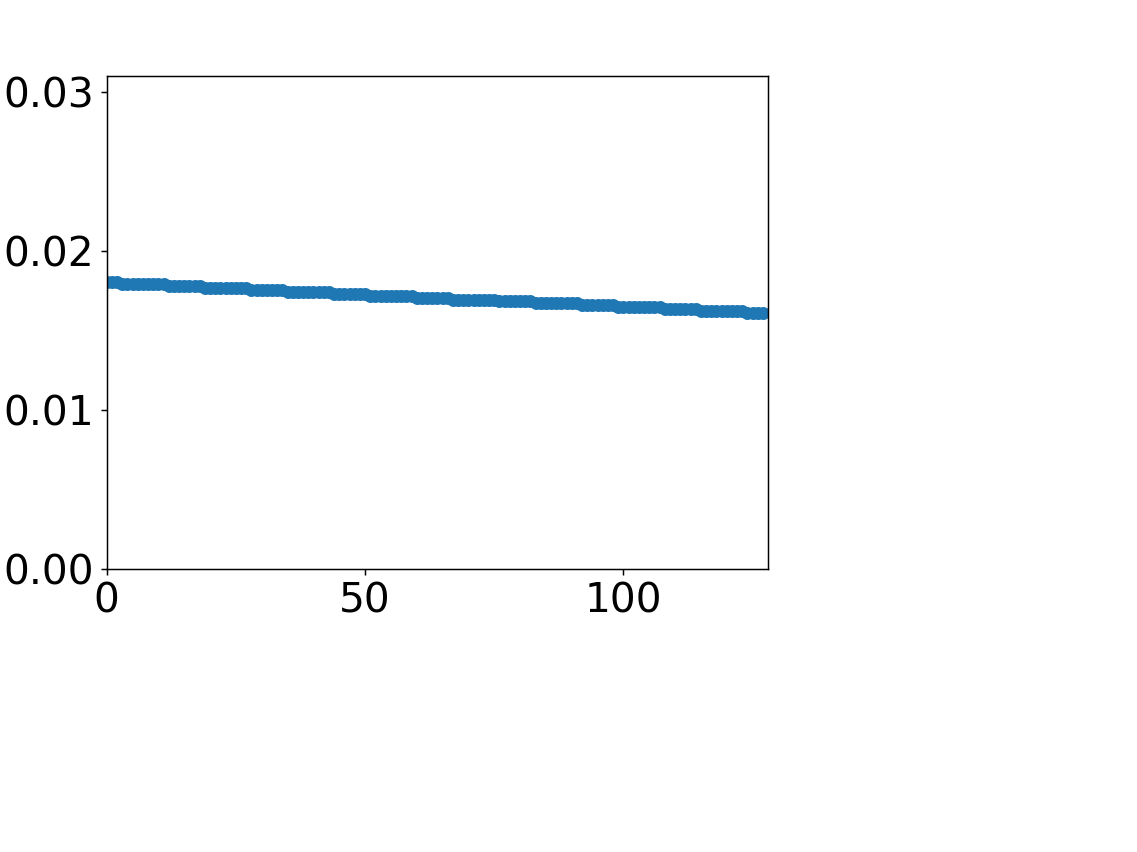

(0.0, 0.031)

In [14]:
from matplotlib import pyplot
import numpy
%matplotlib notebook
righe = numpy.round(numpy.arange(135,151,(151-135)/128)).astype(int)
print(righe)

righe = numpy.flip(righe, axis = 0)

#print(righe*(18e-3/135))
colonne = numpy.arange(righe.size)

pyplot.scatter(colonne, righe*(18e-3/151))
pyplot.xlim(0,128)
pyplot.ylim(0,31e-3)

#### (frequenze[135]-frequenze[151])/(128*4096)vg 

<IPython.core.display.Javascript object>


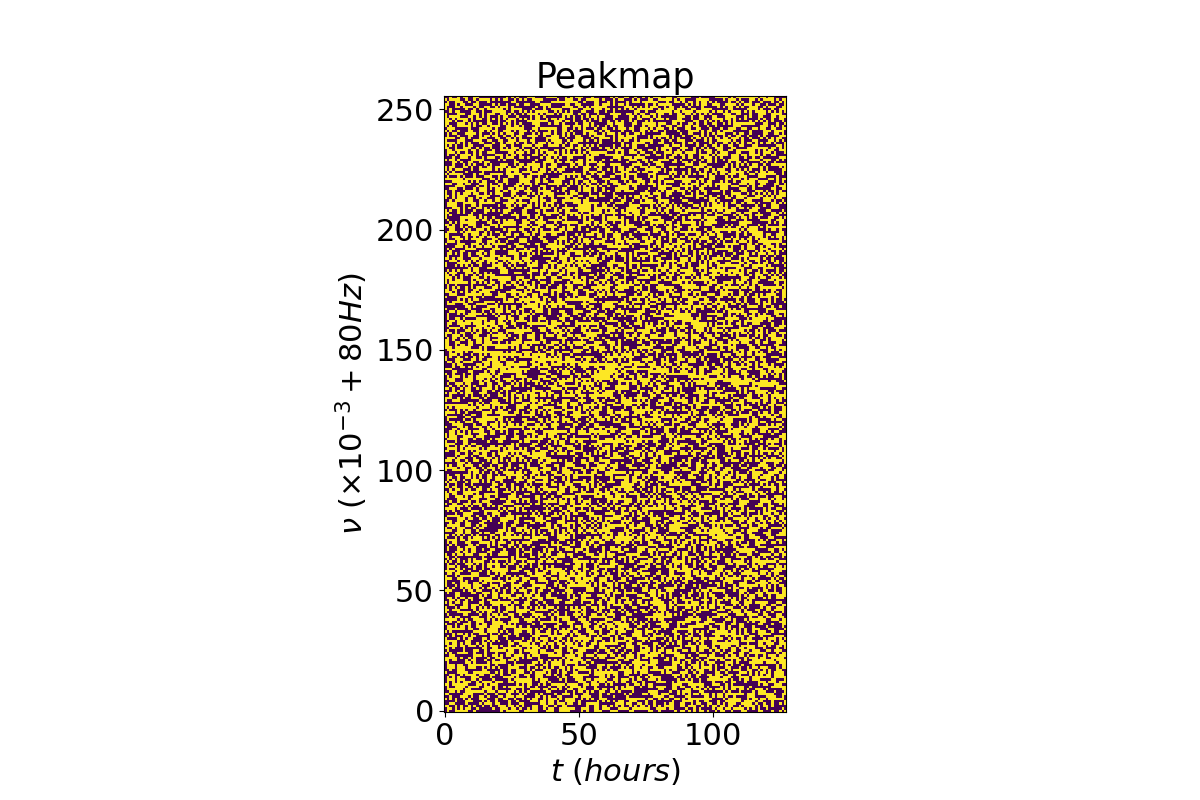

[  0.          45.51111111  91.02222222 136.53333333 182.04444444
 227.55555556 273.06666667]
[80.         80.00610352 80.01220703 80.01831055 80.02441406 80.03051758]


In [21]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib notebook
mpl.rcParams['font.size'] = 22
pyplot.figure(figsize=(12, 8))




#peaklinee = numpy.flip(peaklinee,0)

nonzeri = numpy.nonzero(peakmapTOT)
peakmapTOT[nonzeri] = 1

a = pyplot.imshow(peakmapTOT, cmap = 'viridis', origin = 'lower', interpolation = 'none', aspect = 0.9)



#sdveri = (-0.1953/15)*(numpy.arange(101)-50)
#print(sdveri)

#labelytick = numpy.array([-50, -25, 0, 25, 50])
#sdlabel = numpy.array([0,17,33,50,66,83,100])
#labelytick = sdveri[sdlabel]
#labelytick = [-0.65, -0.43, -0.21, 0, 0.21, 0.43, 0.65]

labelxtick = numpy.array([0,20.0,40.0,60.0,80.0,100.0,120.0])*8192/3600
print(labelxtick)
labelytick = numpy.array([0,50.0,100.0,150.0,200.0,250.0])
labelytick = labelytick/8192+80
print(labelytick)


pyplot.xlabel('$t$ $(hours)$', fontsize = 22)
labelxtick = [0,24,48,72,96,120]
posxTick = [0,23,46,70,93,116]
#pyplot.xticks(posxTick,labelxtick)

pyplot.ylabel('$\\nu$ ($\\times 10^{-3} + 80 Hz$)', fontsize = 22)
labelytick = [0,6,12,18,24,30]
posyTick = [0,50,100,150,200,250]
#pyplot.yticks(posyTick,labelytick)
pyplot.title('Peakmap', fontsize = 25)

pyplot.savefig('compeak.pdf', format='pdf')

In [23]:
144*(1/4096)*1e-3+80

80.00003515625

128
128
80.035009765625
-3.6666666666666674e-10 2.6666666666666657e-10
0.9999999999990905 220.9999999999991


<IPython.core.display.Javascript object>


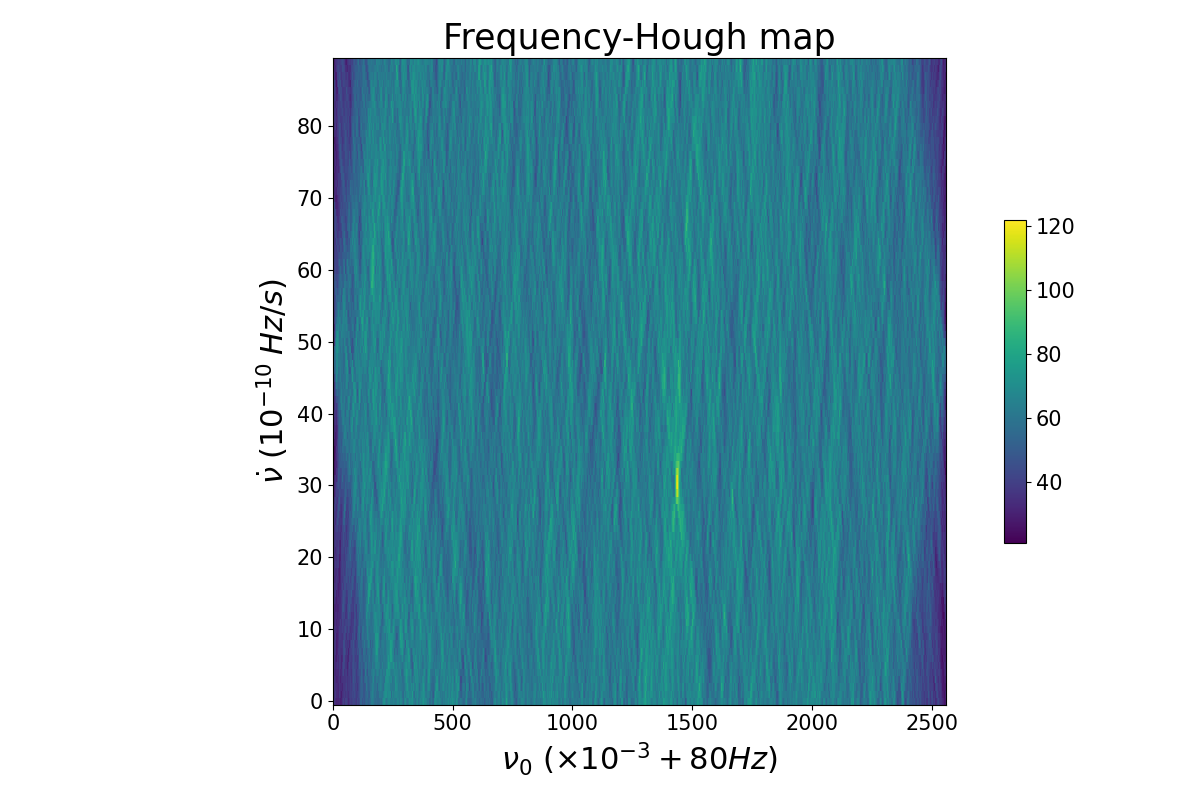

[-8. -6. -4. -2.  0.  2.  4.  6.  8.]


In [24]:
import tensorflow as tf
import numpy
import scipy.io
import time

sessione = tf.Session()

# CARICO DATI

#tFft = 8192

#percorsoDati = "/home/protoss/Documenti/TESI/wn100bkp/data/amplitude_4.mat"


#index = 9002 #signal
#index = 4 #signal meno bello
#index = 5001
#index = 0

#struttura1 = scipy.io.loadmat(percorsoDati)['H']
#peakmap1 = struttura1[index].copy()
#del struttura1

#struttura2 = scipy.io.loadmat(percorsoDati)['L']
#peakmap2 = struttura2[index].copy()
#del struttura2

#struttura3 = scipy.io.loadmat(percorsoDati)['V']
#peakmap3 = struttura3[index].copy()
#del struttura3


#strutturaTOT = struttura1 + struttura2 #+ struttura3


###############################


def noncorr():
	freqMin = numpy.amin(frequenze)
	freqIniz = freqMin - stepFreq/2 -stepFreqRaffinato
	freqNonCor = (frequenze -freqIniz)/stepFreqRaffinato-round(enhancement/2+0.001)
	#freqNonCor = tf.constant(freqNonCor, dtype = tf.float32)
	return freqNonCor, freqIniz


def inDaHough(freqHM):
	#calcola la hough per ogni step di spindown
	def houghizza(stepIesimo):
		sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
		#sdTimed = tf.cast(sdTimed, dtype=tf.float32)
	
		appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
		appoggio = tf.cast(appoggio, dtype=tf.int32)
		
		valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
		return valorisx

	houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

	def sliceInt():
		#faccio integrazione finale (vecchia versione senza conv)
		semiLarghezza = tf.round(enhancement/2+0.001)
		semiLarghezza = tf.cast(semiLarghezza, tf.int32)
		houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
		houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
		return houghInt

	
	hough = sliceInt()
	#hough = convInt()
	houghinal = tf.cumsum(hough, axis = 1)
	
	return houghinal
	#return houghDiff
    
    


#tFft = 4096
#tObs = 1/5 #mesi
#tObs = tObs*30*24*60*60
#nPunti = 2
#cands = 32
#primaFreq = 1/tFft

#maximumCand = numpy.array()

nIndexes = 10
#nIndexes = strutturaTOT.shape[0]
allMaxCands = numpy.zeros((nIndexes,4,5))

#peakmapTOT = strutturaTOT[index]

#del struttura1
#del struttura2
#del struttura3

colonne = numpy.arange(peakmapTOT.shape[1])
print(colonne.size)
righe = numpy.round(numpy.arange(135,151,(151-135)/128)).astype(int)
righe = numpy.flip(righe,0)
print(righe.size)

peakmapTOT[righe,colonne] = 1

sparsa = numpy.nonzero(peakmapTOT)

frequenze,tempi = sparsa
tempi = tempi+1
frequenze = frequenze / tFft + 1
pesi = numpy.ones(sparsa[0].size)




#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 2000
#securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
#enhancement = 1
stepFreqRaffinato =  stepFreq/enhancement
nstepsFreq = securbelt+(numpy.amax(frequenze)-numpy.amin(frequenze) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato
print(1434*stepFreqRaffinato+80)

epoca = numpy.int(128/2)

#spindowns
spindownMin = -10e-10
spindownMax = 9e-10
nstepSpindown = 90
stepSpindown = (spindownMax-spindownMin)/nstepSpindown

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)
print(spindowns[30], spindowns[-30])
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi, dtype=tf.float64)

pesiTF = tf.constant(pesi,dtype=tf.float32)

spindownsTF = tf.constant(spindowns, dtype=tf.float32) 

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float32)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int32)

nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

freq, freqIn = noncorr()

print(freq[0], freq[1434])

freqTF = tf.constant(freq, dtype = tf.float32)
houghmap = inDaHough(freqTF)
hough = sessione.run(houghmap)


from matplotlib import pyplot
import matplotlib as mpl
%matplotlib notebook
mpl.rcParams['font.size'] = 15
pyplot.figure(figsize=(12, 8))

a = pyplot.imshow(hough[:,1000:-1000], cmap = 'viridis', origin = 'lower', interpolation = 'none', aspect = 30)

labelxtick = [0,6,12,18,24,30]
posxTick = [0,500,1000,1500,2000,2500]
#pyplot.xticks(posxTick,labelxtick)

labelytick = numpy.arange(-8,8.1,2)
print(labelytick)
posyTick = [7,17,27,37,47, 57,67,77,87]
posyTick = numpy.round(numpy.arange(0,spindowns.size, spindowns.size/9 )).astype(int)
labelytick = spindowns[posyTick]

#pyplot.yticks(posytick,labelytick)
pyplot.xlabel('$\\nu_0$ ($\\times 10^{-3} + 80 Hz$)',fontsize = 22)
pyplot.ylabel('$\dot{\\nu} \;(10^{-10}\:Hz/s)$', fontsize = 22 )

#pyplot.xticks(posxTick,labelxtick)
#pyplot.yticks(posyTick,labelytick)

pyplot.colorbar(shrink = 0.5,aspect = 15)
pyplot.title('Frequency-Hough map', fontsize = 25 )
pyplot.tight_layout()


pyplot.savefig('comphough.pdf', format='pdf')

In [35]:
zeri = numpy.where(hough[:,1000:-1000] == 0)
zeri

(array([86, 86]), array([2529, 2530]))

In [19]:
indici[0].nbytes/1e6

3.27024

408780 408780 408780


<IPython.core.display.Javascript object>


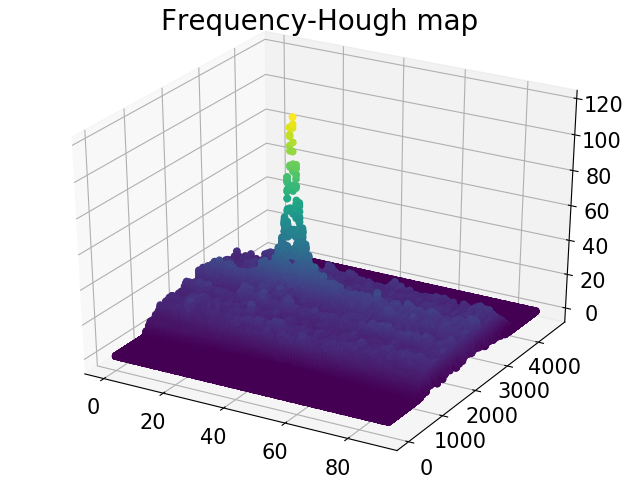

In [17]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

#%matplotlib notebook
indici = numpy.where(hough<1e6)
righe = indici[0]
colonne = indici[1]
valori = numpy.ravel(hough)

print(righe.size, colonne.size, valori.size)



fig = plt.figure()

ax = Axes3D(fig) #<-- Note the difference from your original code...

# Plot the values
ax.scatter(righe, colonne, valori, c = valori, cmap = "viridis", marker='o', alpha = 1)
pyplot.title('Frequency-Hough map', fontsize = 20 )
pyplot.savefig('3dcomphough.pdf', format='pdf')
#pyplot.tight_layout()

In [26]:
from scipy import sparse

sparsh = sparse.csr_matrix(hough[:,1000:-1000])


In [30]:
print(sparsh.shape)

(90, 2542)
